In [4]:
! pip install -U layoutparser


Defaulting to user installation because normal site-packages is not writeable


In [5]:
! pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-yda_t6d0/detectron2_ac3ac7b9d6184032941ba60bfa525059
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-yda_t6d0/detectron2_ac3ac7b9d6184032941ba60bfa525059
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done
  Using cached fvcore-0.1.3.post20210317-py3-none-any.whl
  Created wheel for detectron2: filename=detectron2-0.4-cp39-cp39-linux_aarch64.whl size=5708334 sha256=0f12dfc2c3d2652dda0f7453c963bcc707f5eb8046116d7398a31299840a6dae
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2uwelg6/wheels/54/2b/7b/3d70364c8274455445b2611adf7f48be12c7816ffae4e34c8a
Successfull

In [6]:
! pip install layoutparser[ocr]

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.4/918.4 kB 64.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.22.3
    Uninstalling protobuf-4.22.3:
      Successfully uninstalled protobuf-4.22.3


In [6]:
import cv2
import layoutparser as lp
import os
import random
import torch
import torchvision.ops.boxes as bops

In [7]:
img_path = "/home/mdscanner/dataset/"+random.choice(os.listdir("/home/mdscanner/dataset"))
print(img_path)
image = cv2.imread(img_path)
image = image[..., ::-1] 


/home/mdscanner/dataset/x111b27eade4155ba.md-base-6.jpg


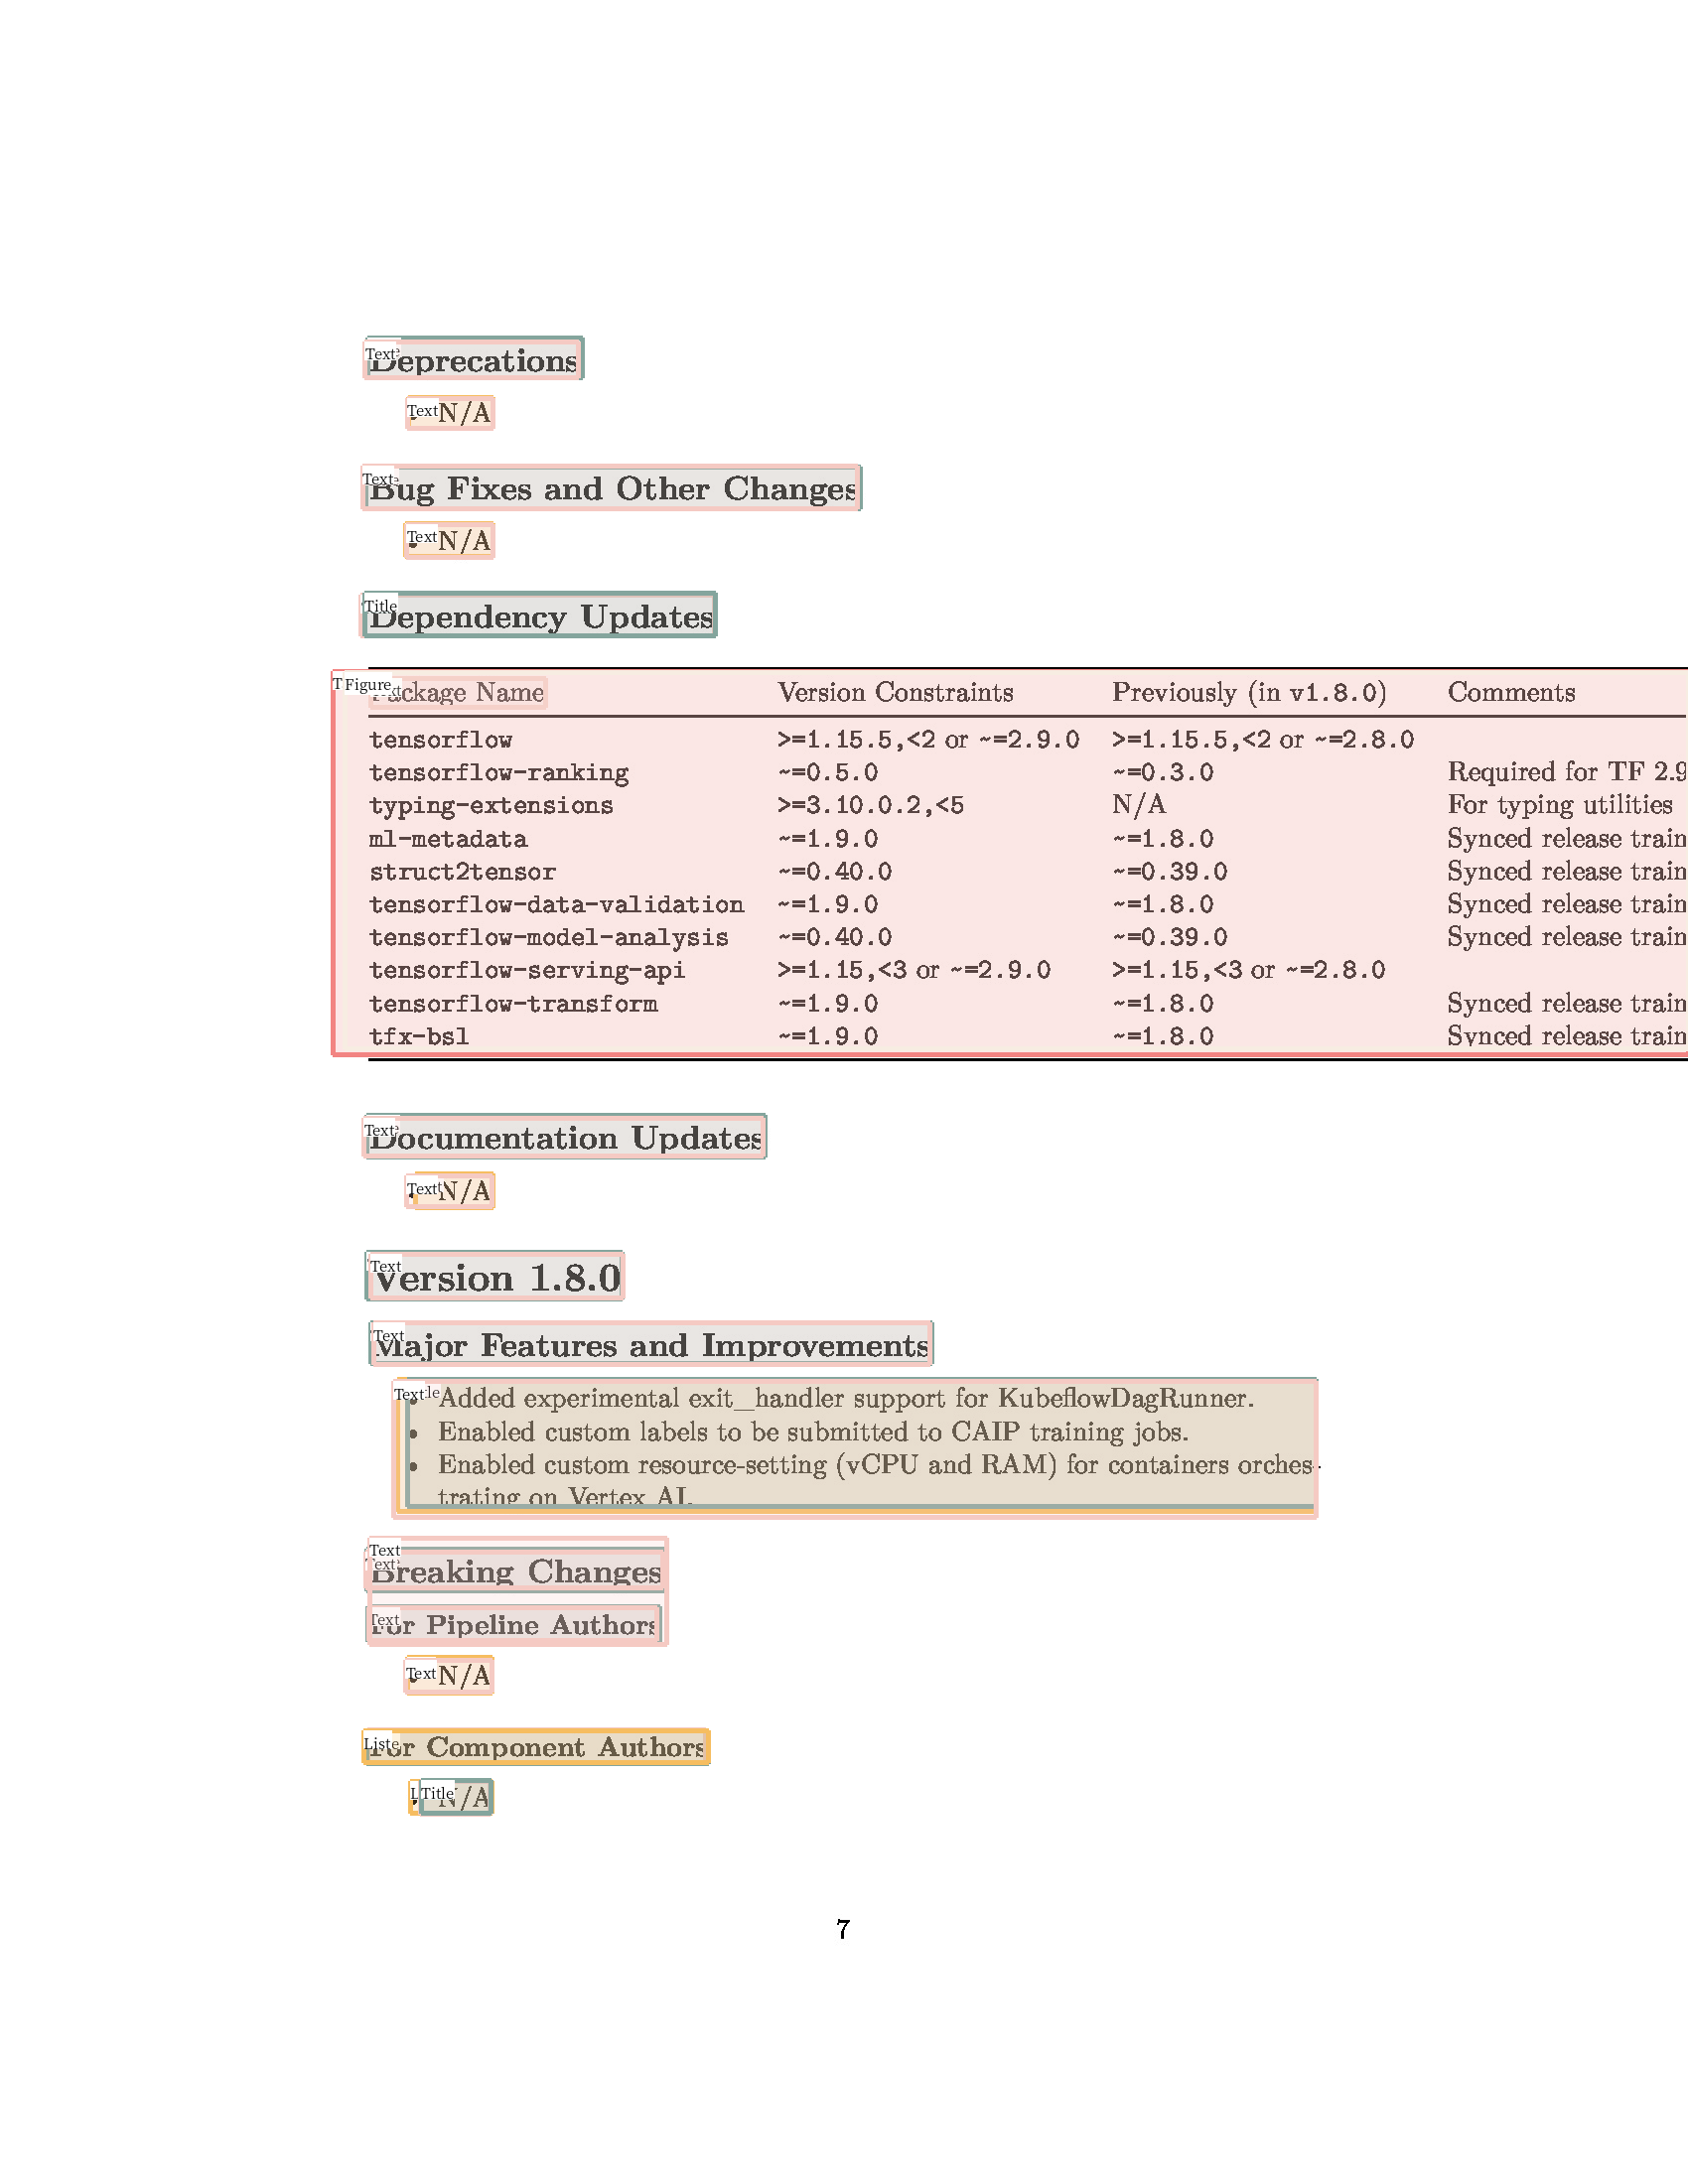

In [8]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 #extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,  box_width=5, box_alpha=0.2, show_element_type=True)






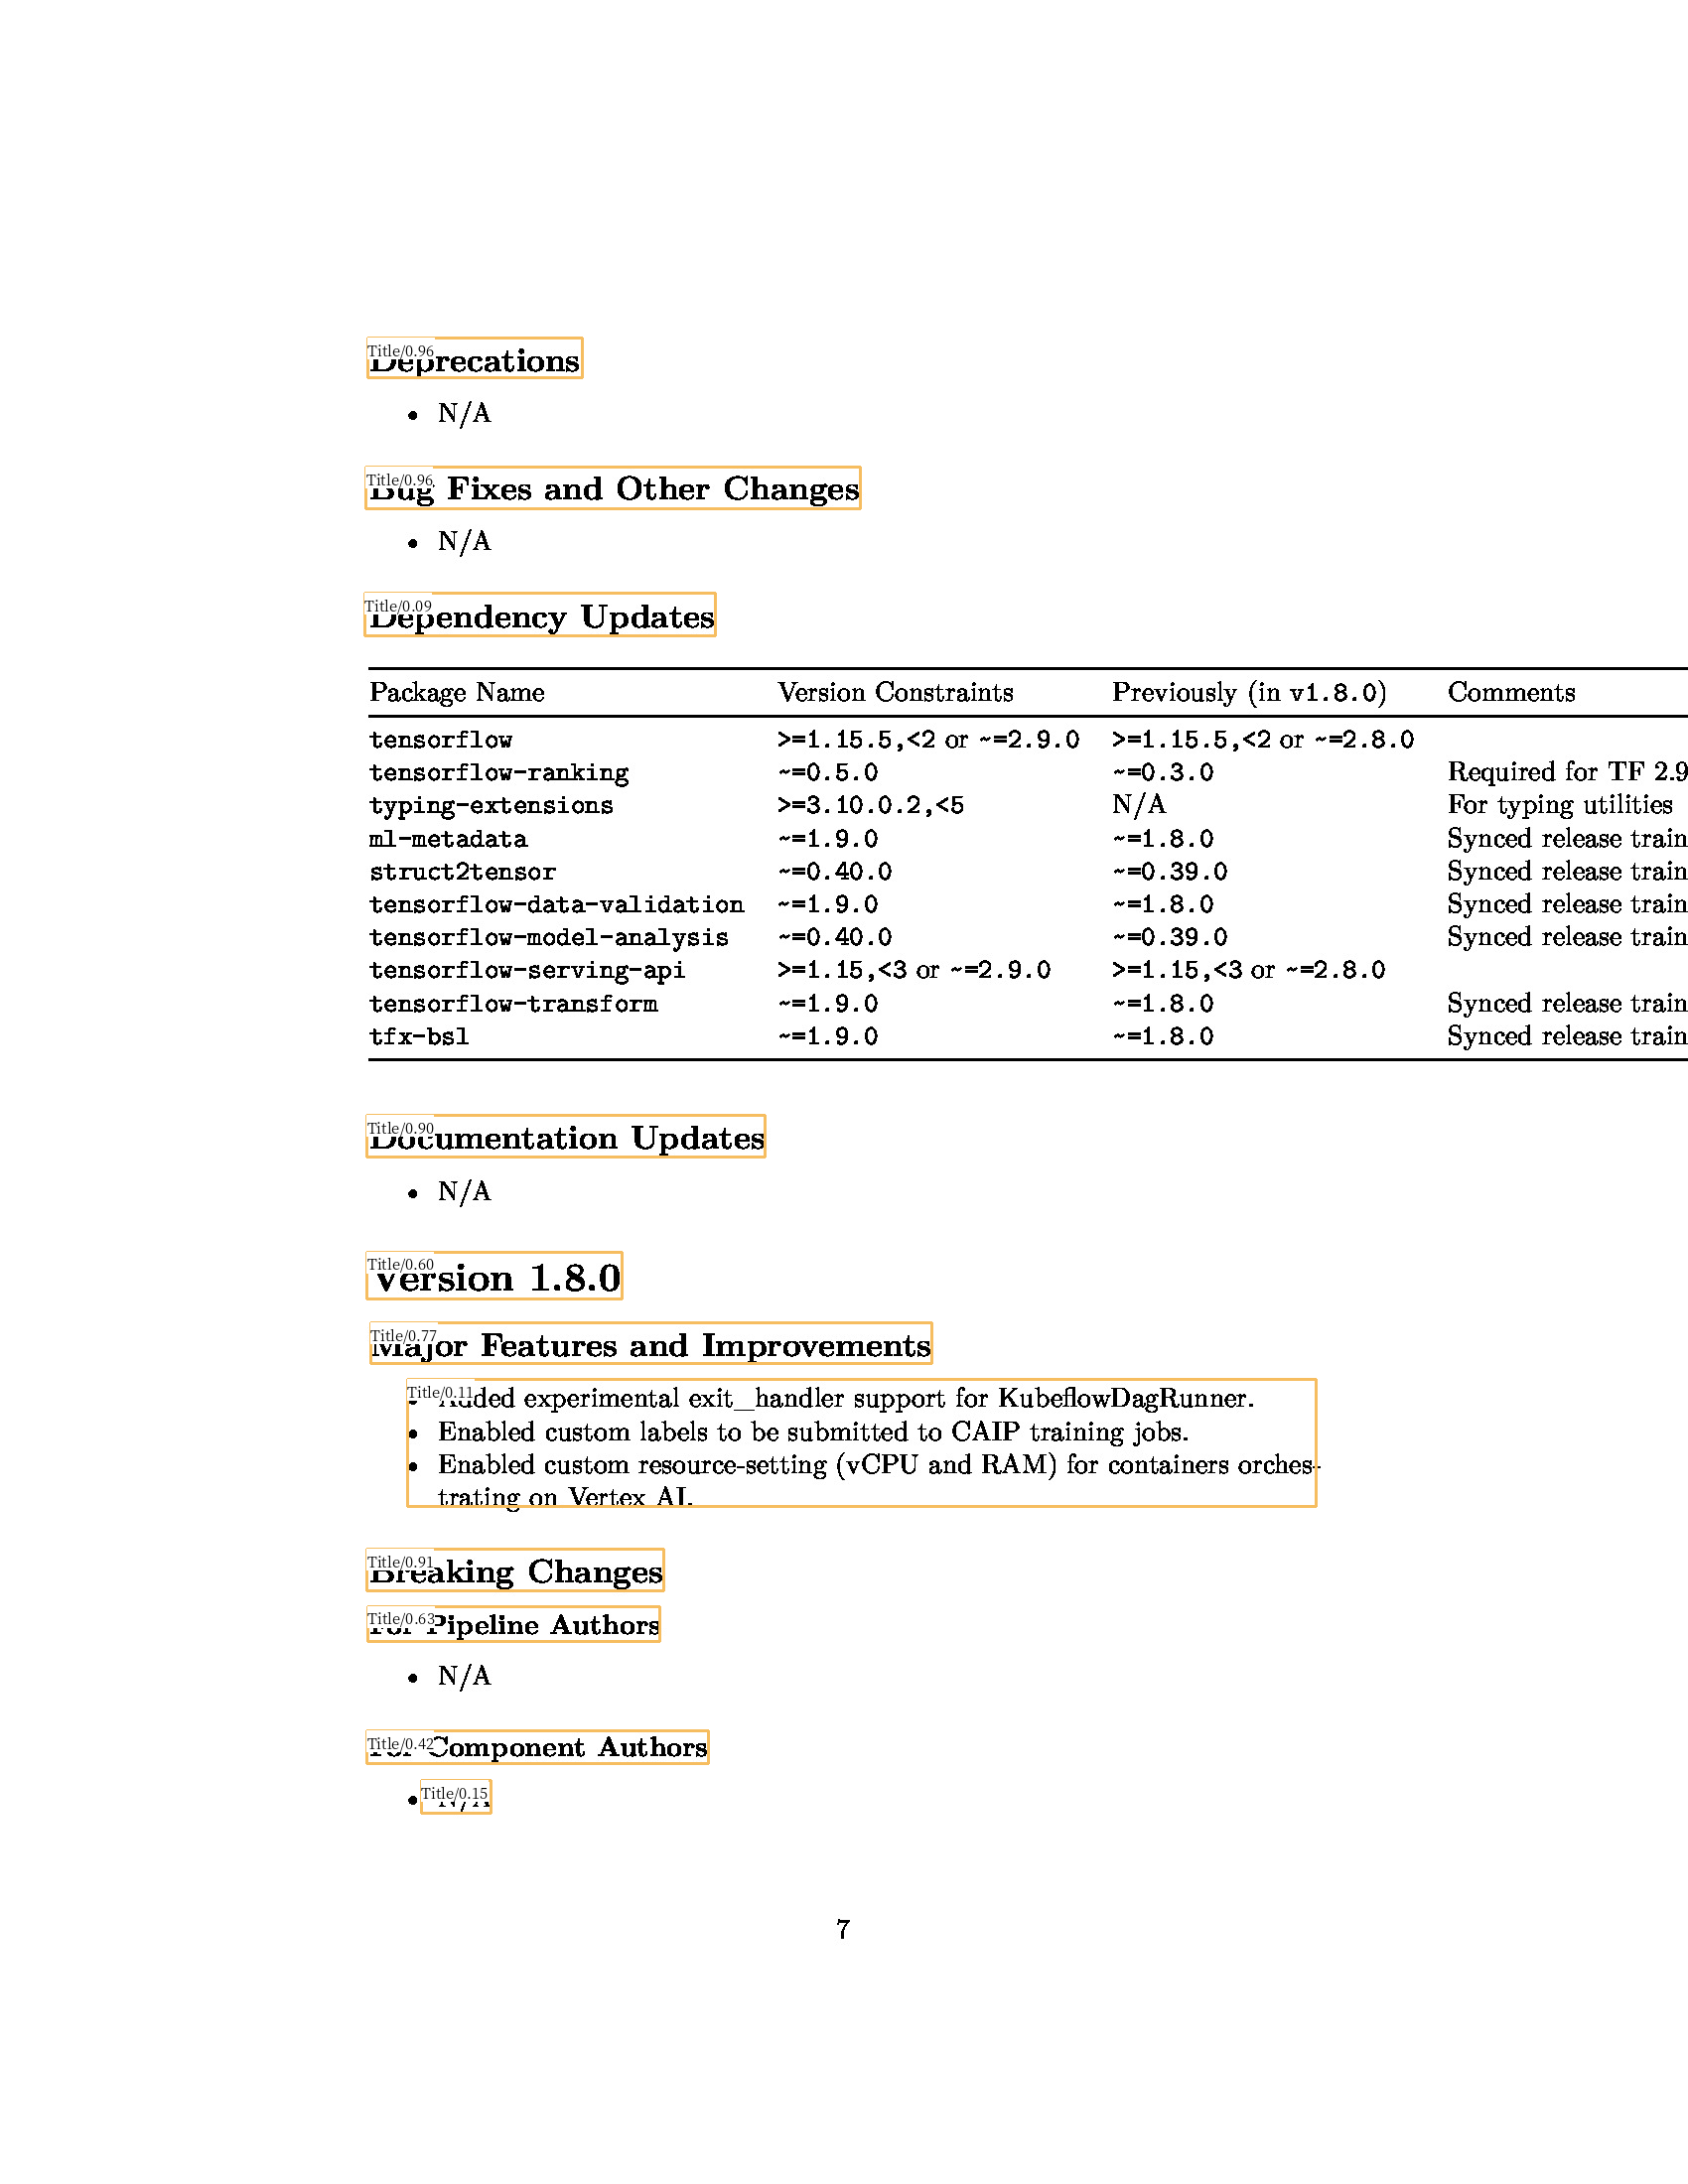

In [9]:
title_blocks = lp.Layout([b.set(id=f'{b.type}/{b.score:.2f}') for b in layout if b.type=='Title'])
title_blocks

lp.draw_box(image, title_blocks,
            box_width=3,
            show_element_id=True)

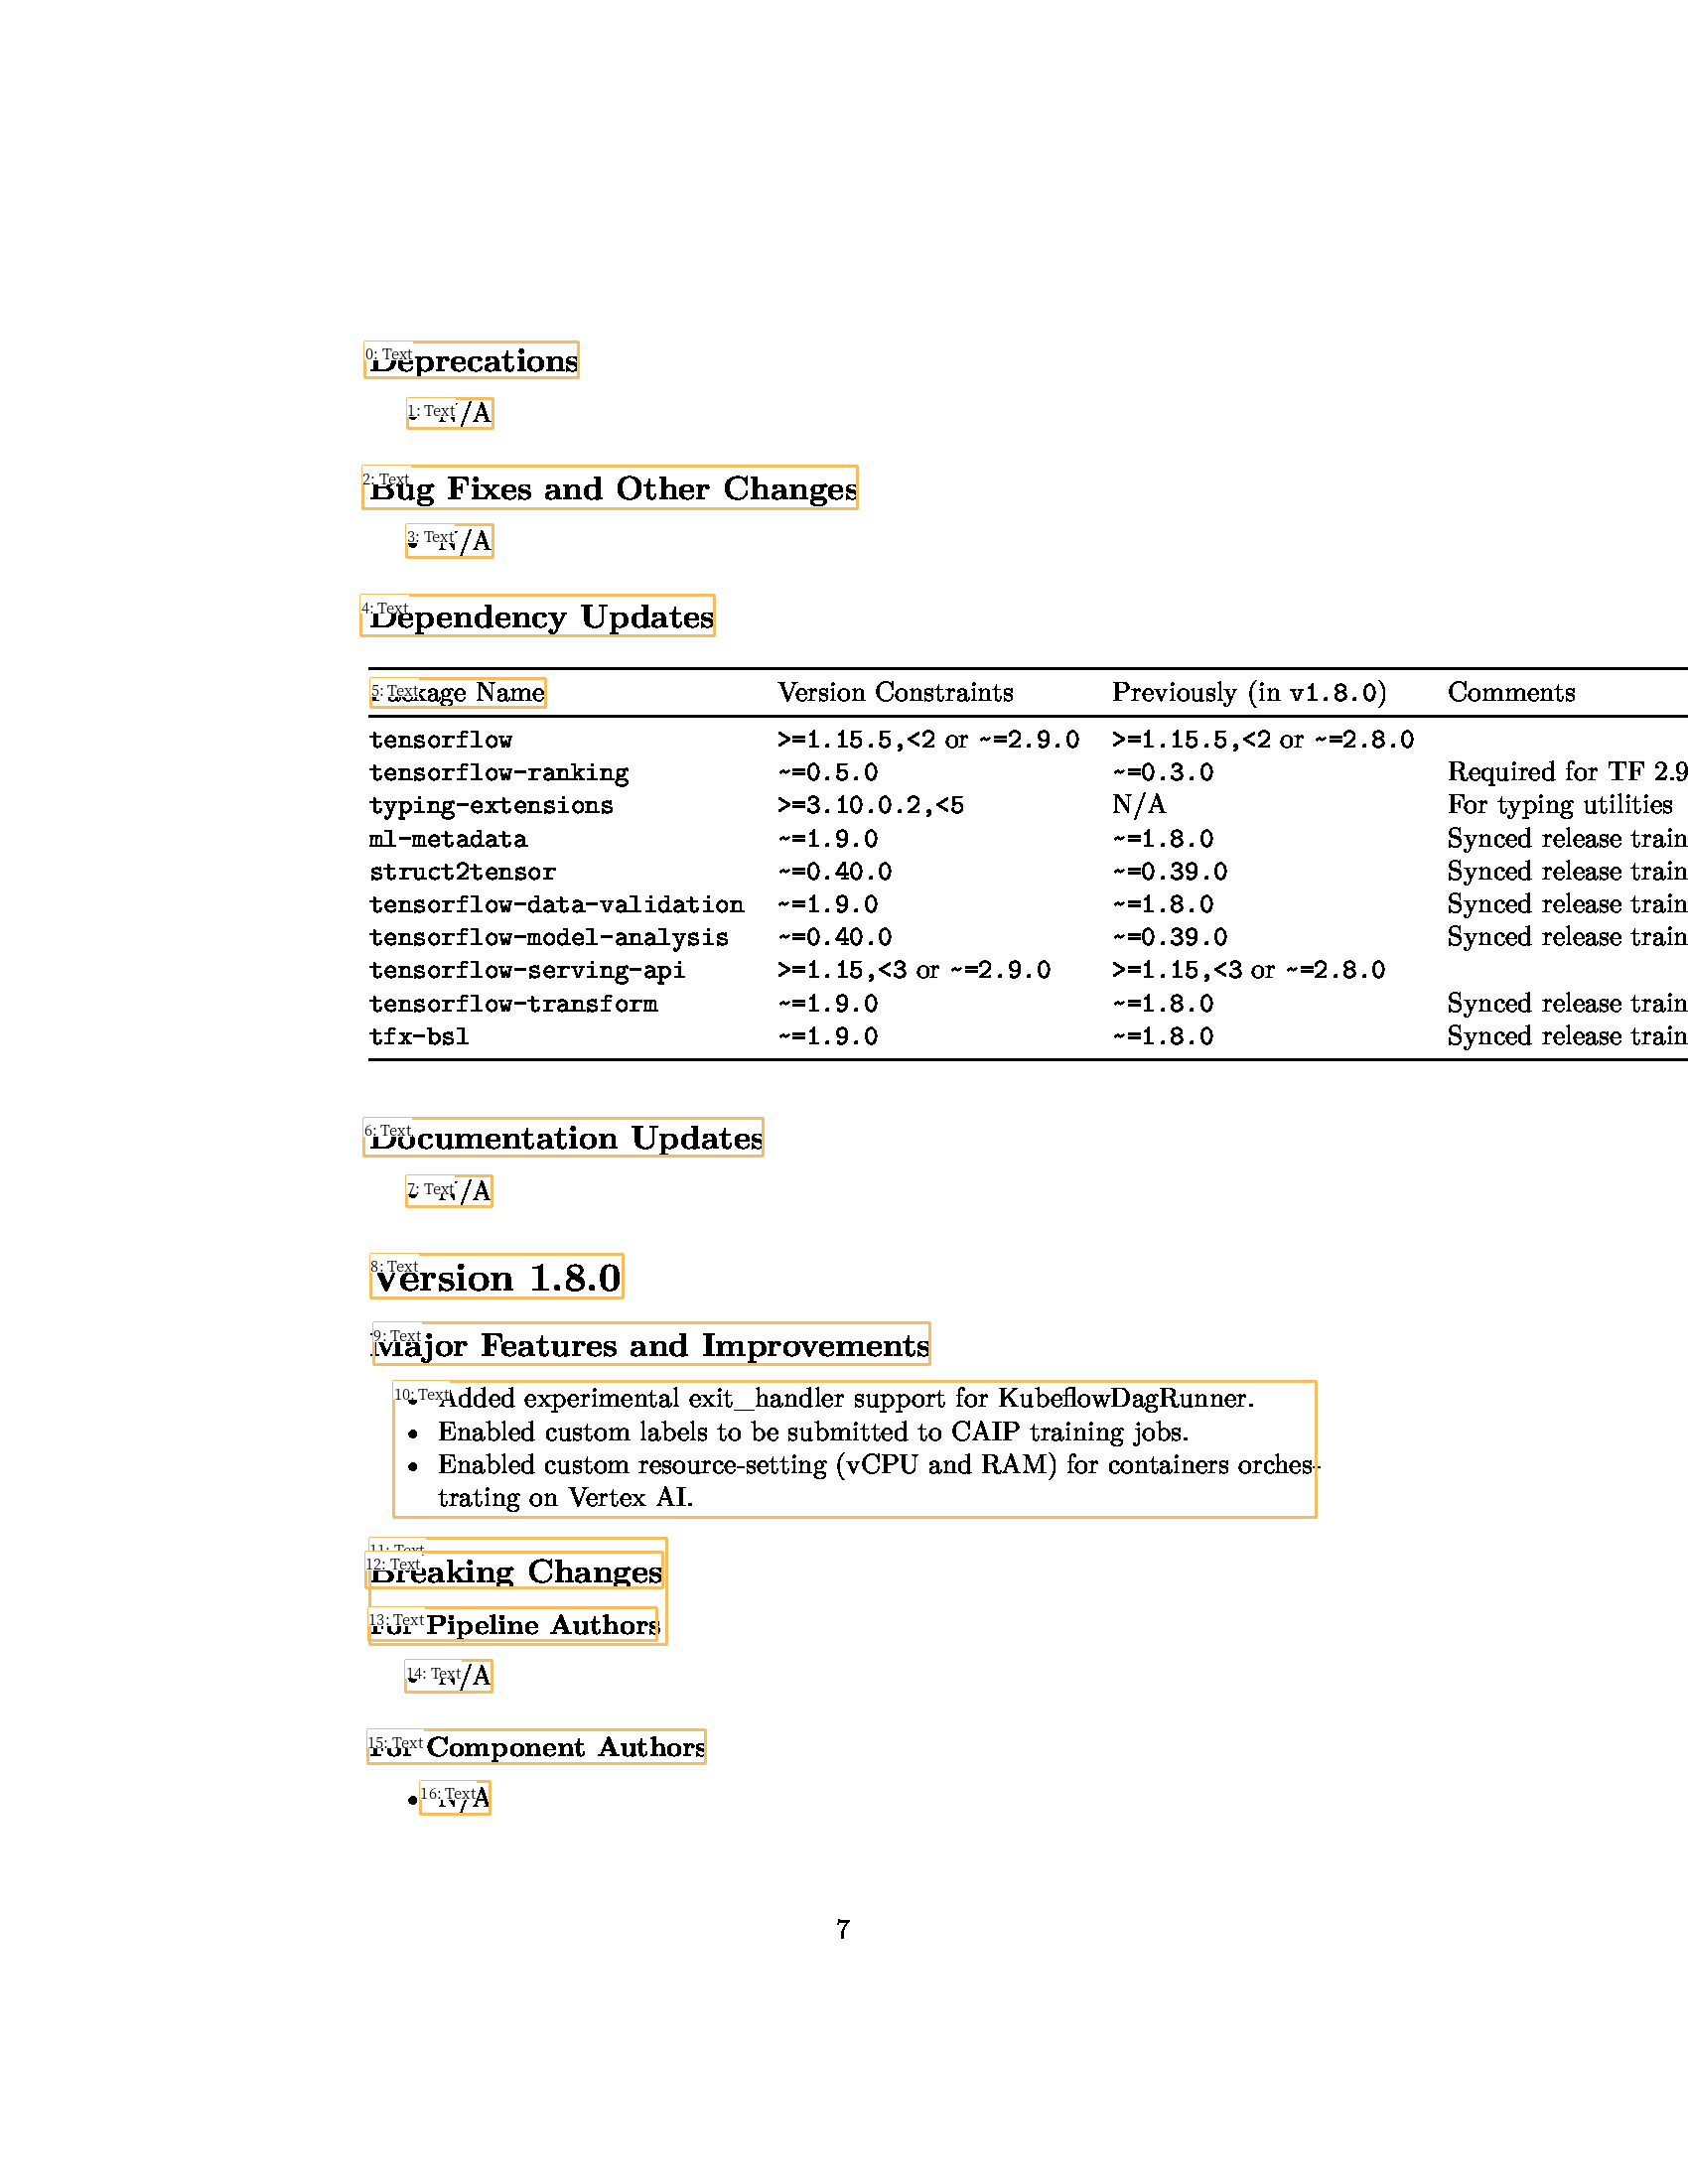

In [10]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])


ord_blocks = text_blocks._blocks
ord_blocks.sort(key = lambda b:b.coordinates[1])

text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(ord_blocks)])

lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_type=True,
            show_element_id=True)

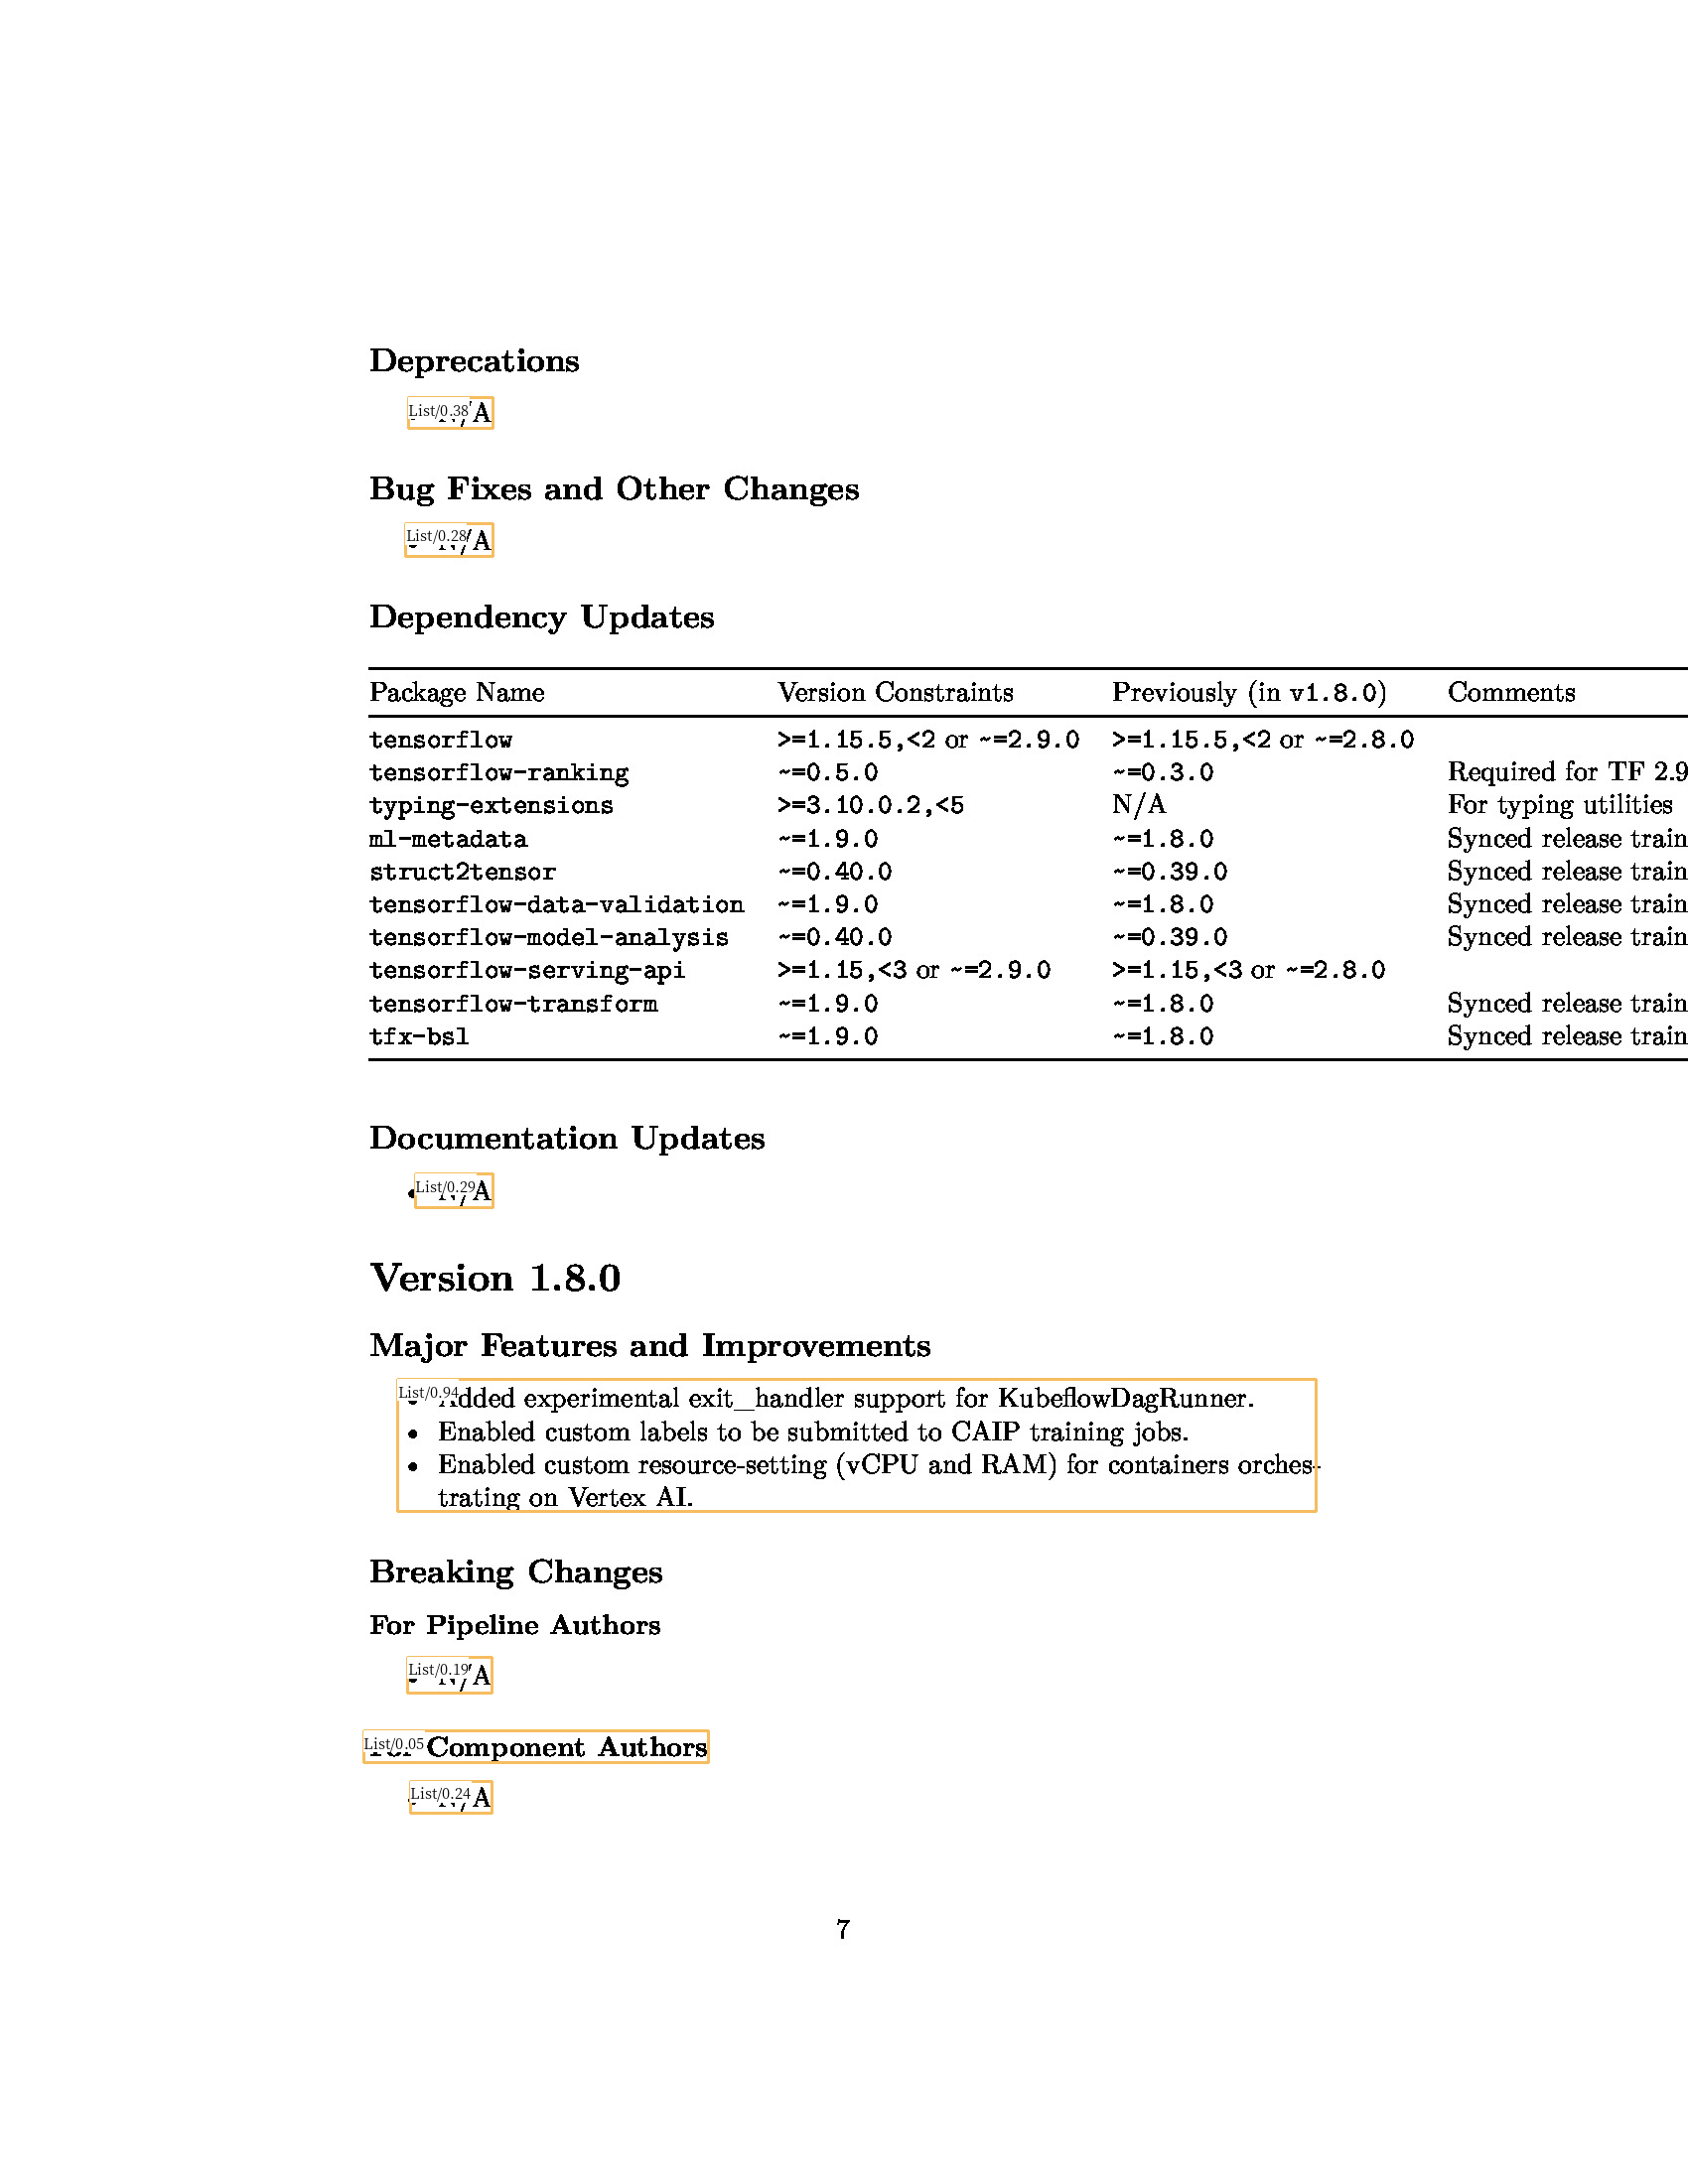

In [11]:
list_blocks = lp.Layout([b.set(id=f'{b.type}/{b.score:.2f}') for b in layout if b.type=='List'])
list_blocks

lp.draw_box(image, list_blocks,
            box_width=3,
            show_element_id=True)

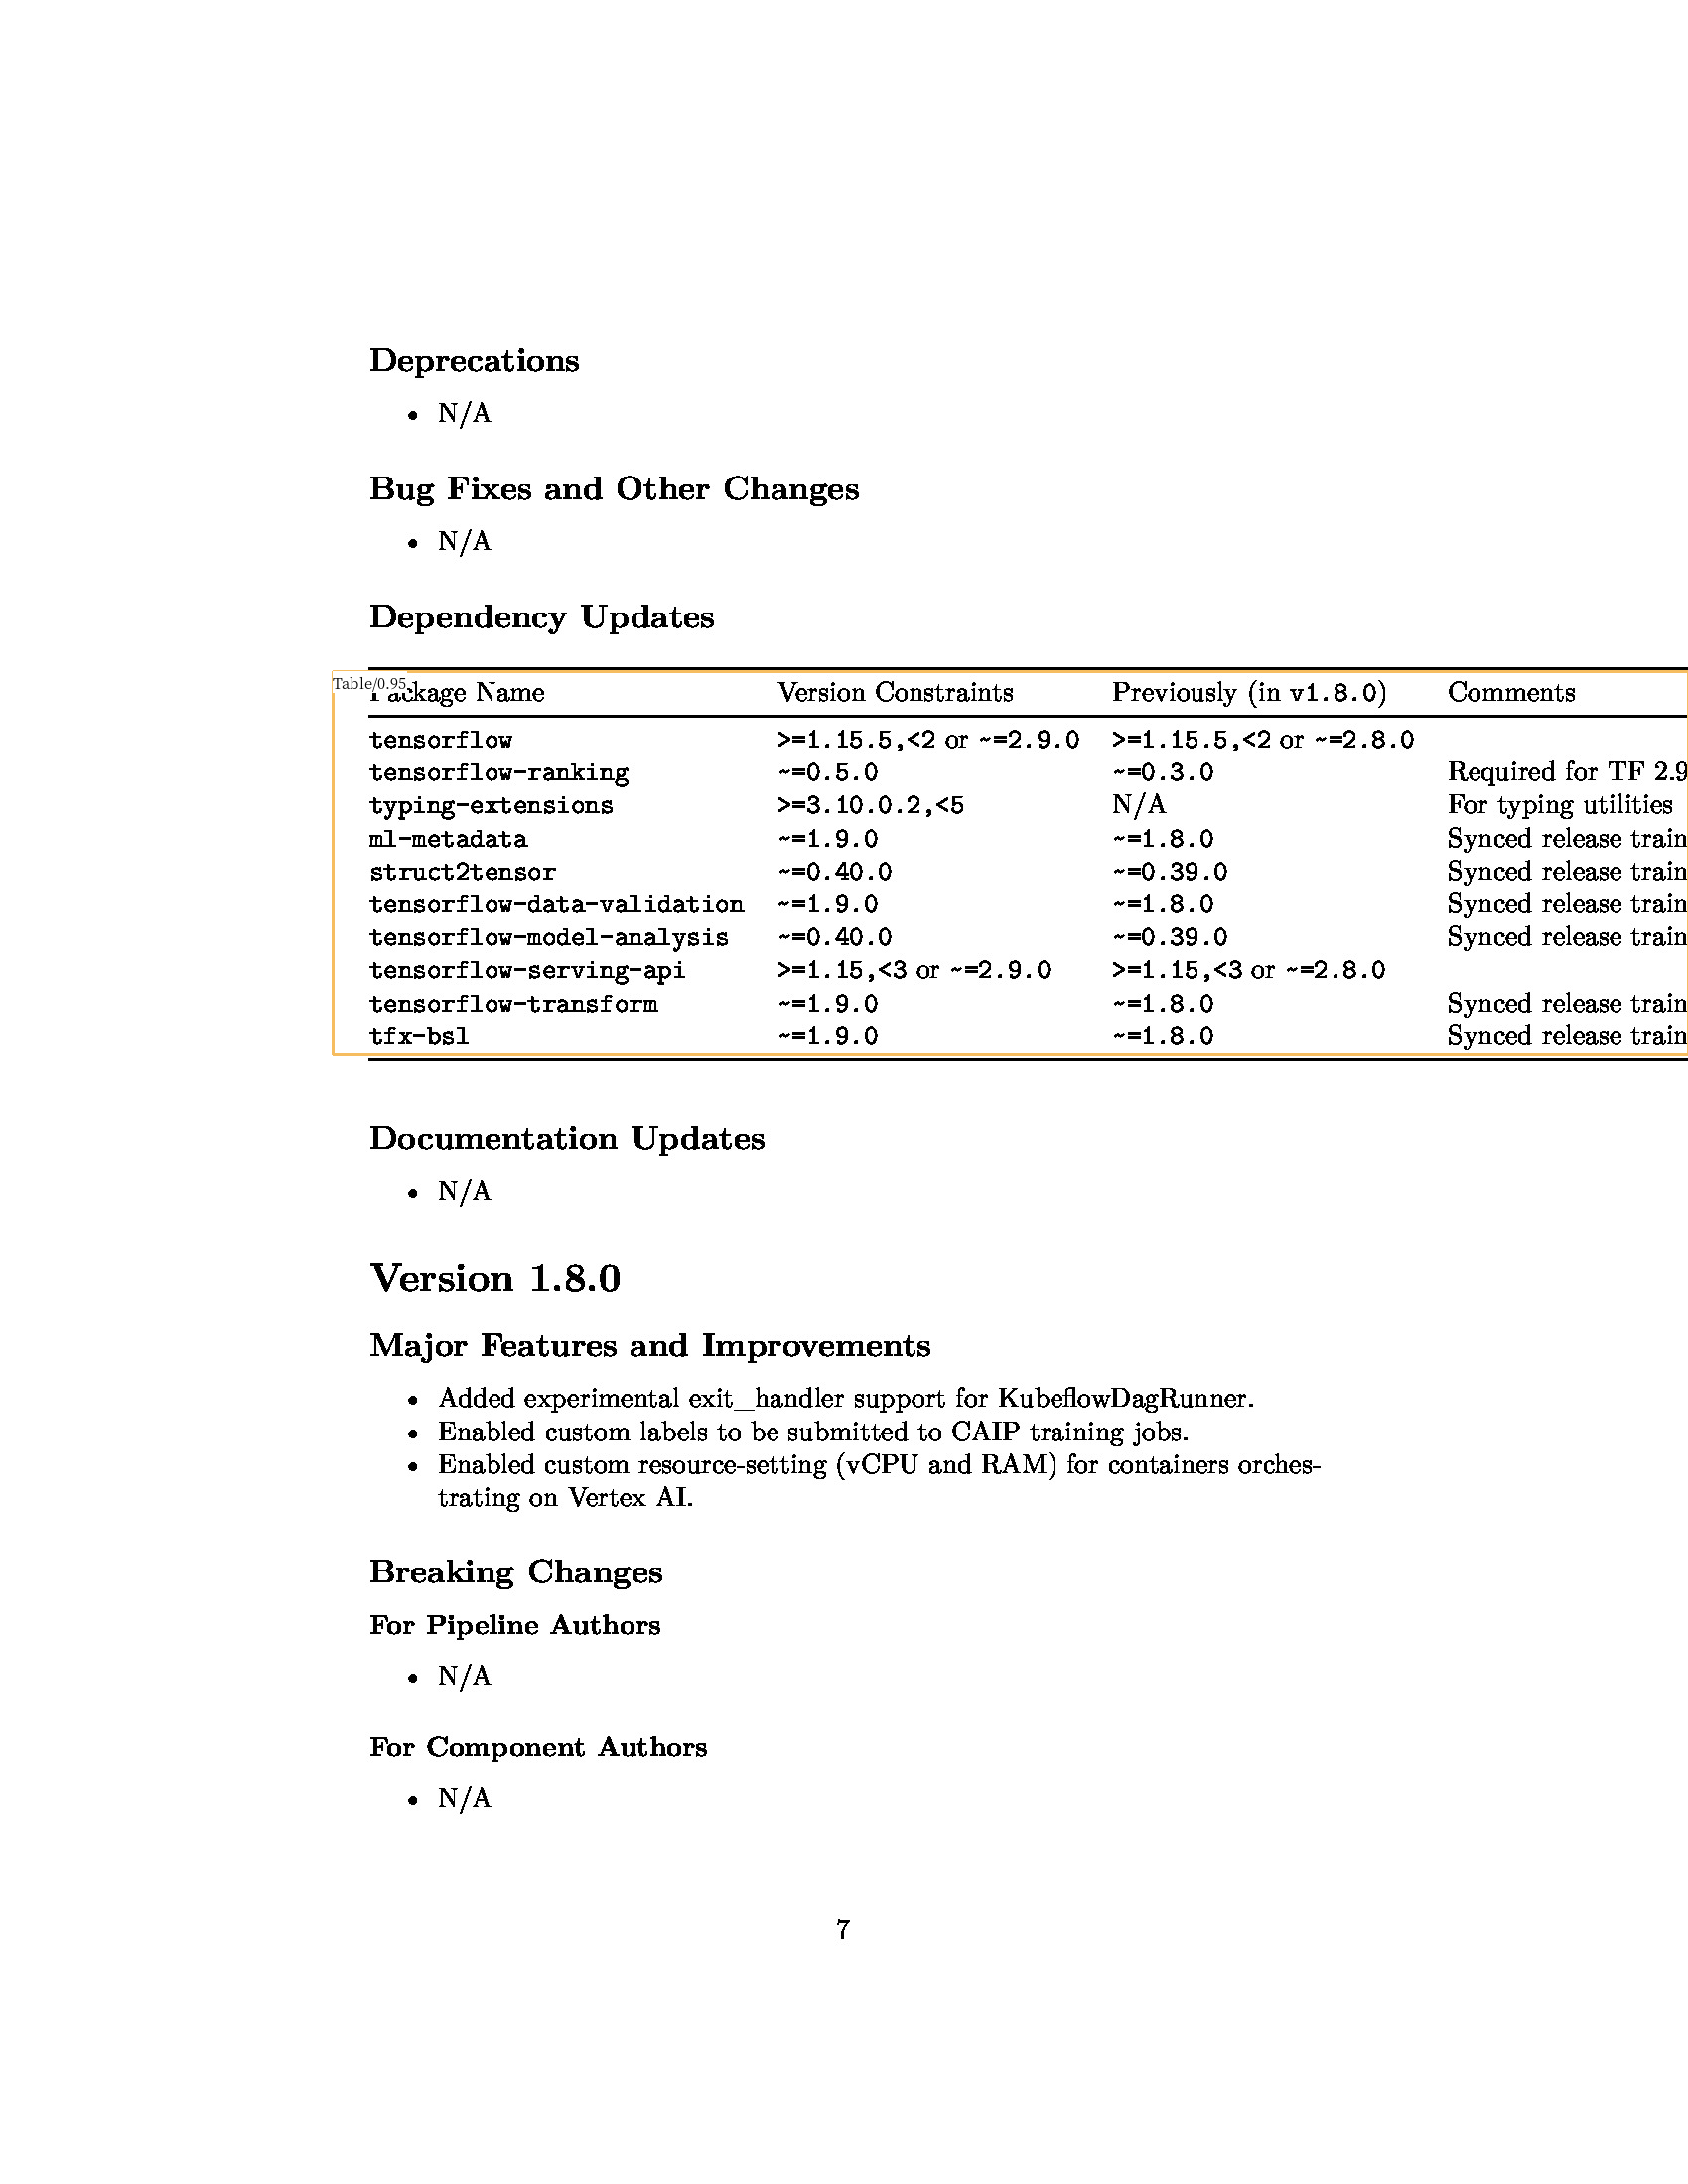

In [12]:
table_blocks = lp.Layout([b.set(id=f'{b.type}/{b.score:.2f}') for b in layout if b.type=='Table'])
table_blocks

lp.draw_box(image, table_blocks,
            box_width=3,
            show_element_id=True)

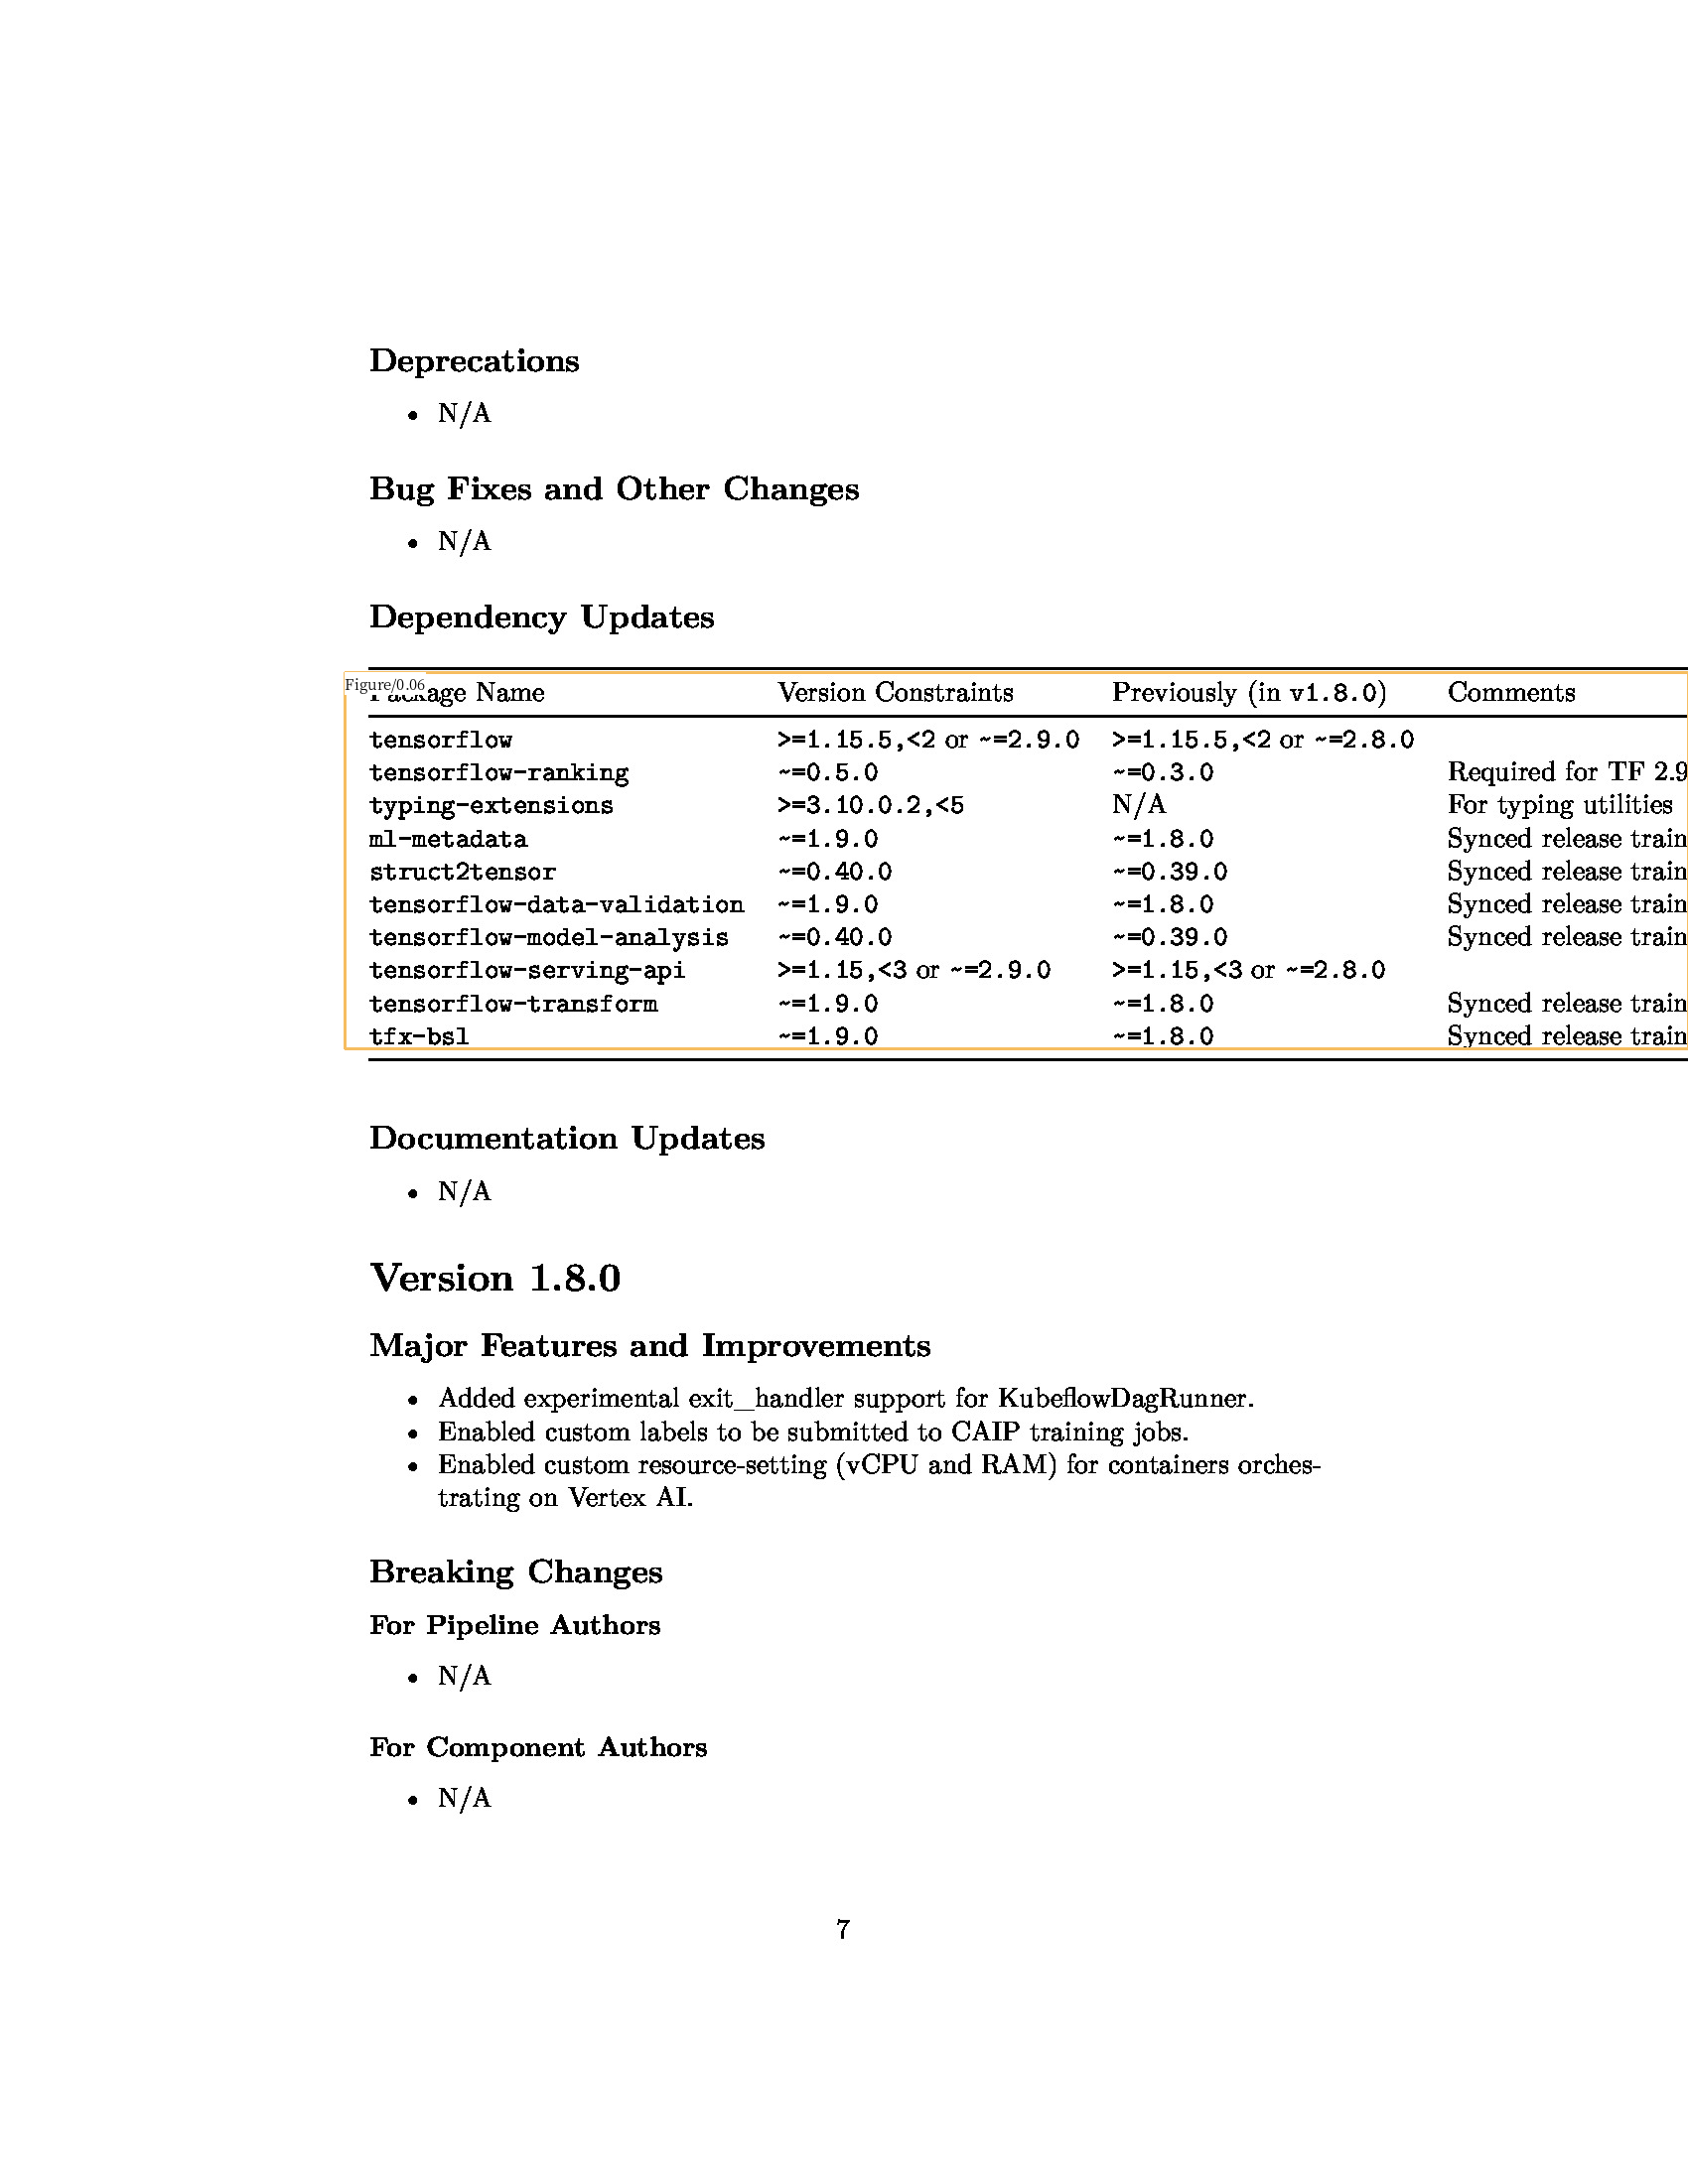

In [13]:
figure_blocks = lp.Layout([b.set(id=f'{b.type}/{b.score:.2f}') for b in layout if b.type=='Figure'])
figure_blocks

lp.draw_box(image, figure_blocks,
            box_width=3,
            show_element_id=True)

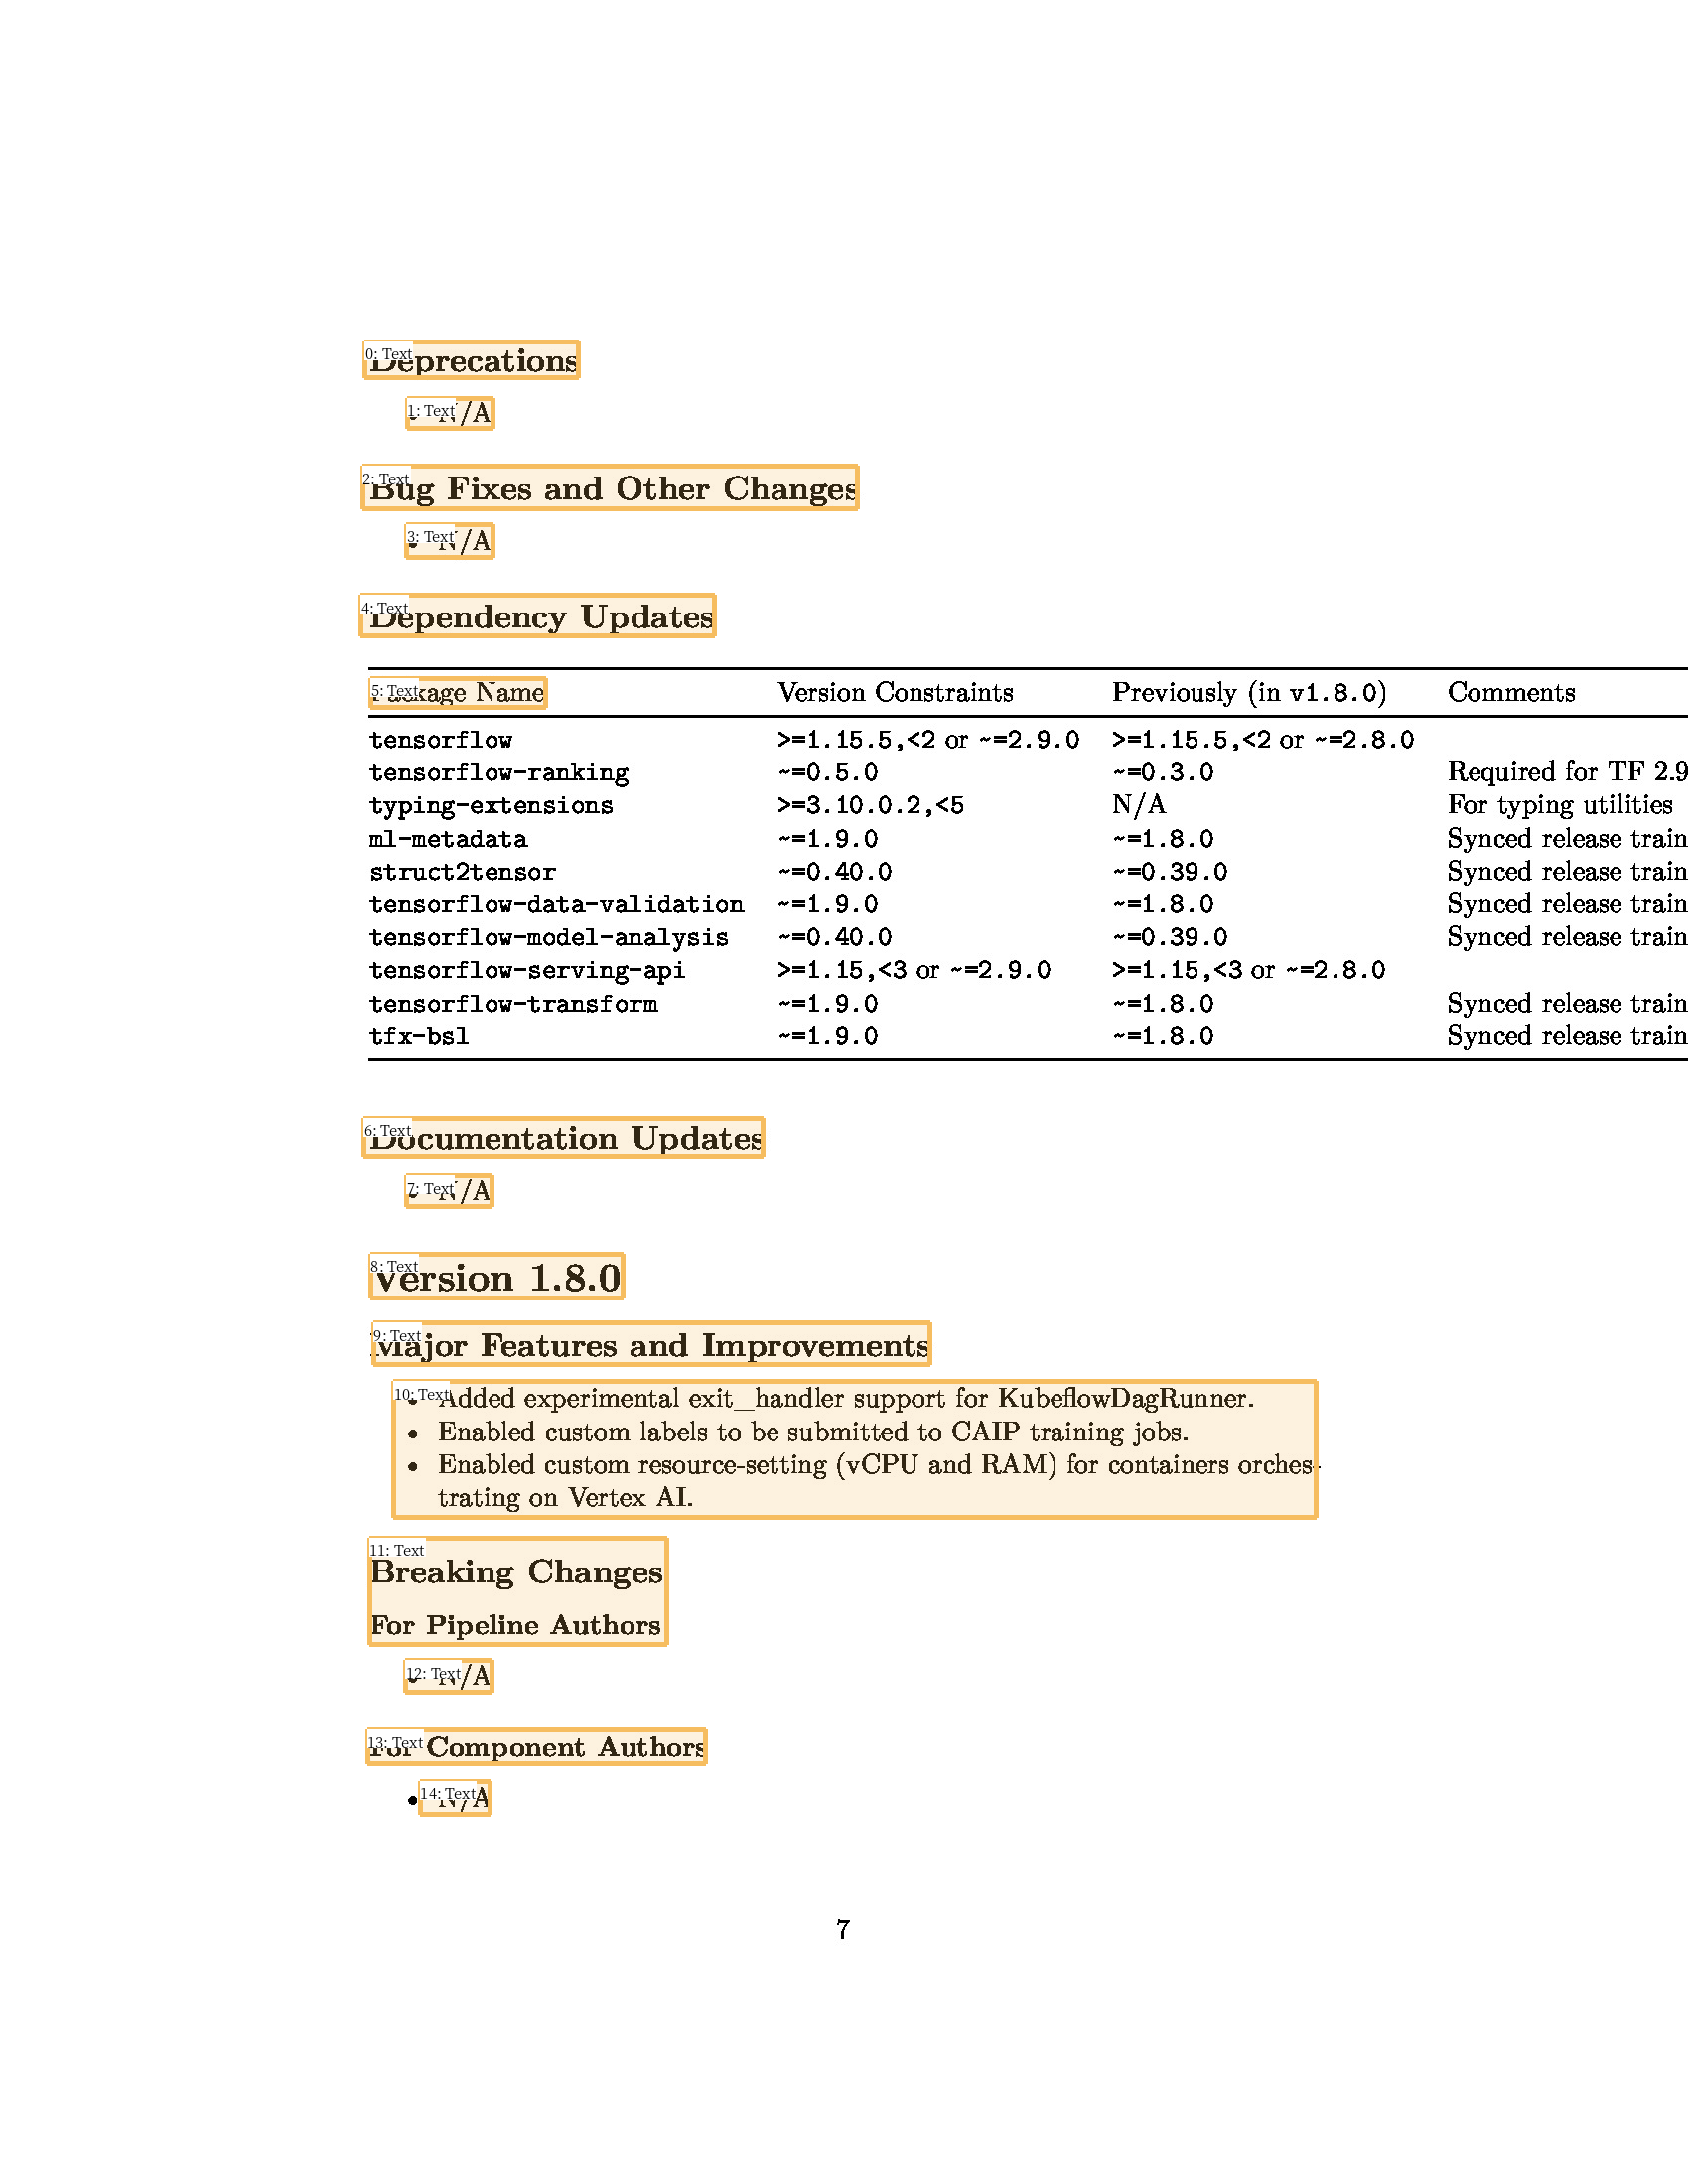

In [14]:
def set_coordinate(data):
    x1= data.block.x_1
    y1= data.block.y_1
    x2= data.block.x_2
    y2= data.block.y_2
    return torch.tensor([[x1,y1,x2,y2]], dtype=torch.float)

def compute_iou(box_1,box_2):
    return bops.box_iou(box_1,box_2)

def compute_area(box):
    width = box.tolist()[0][2] - box.tolist()[0][0]
    length = box.tolist()[0][3] - box.tolist()[0][1]
    
    return width*length

def refine(block_1, block_2):
    # compure bounding boxes
    bb1 = set_coordinate(block_1)
    bb2 = set_coordinate(block_2)

    # compute Intersection over Union
    iou = compute_iou(bb1,bb2)

    # check if bb are overlapped
    if iou.tolist()[0][0] != 0:
        a1 = compute_area(bb1)
        a2 = compute_area(bb2)

        # discard bb with smaller area
        block_2.set(type='None', inplace=True) if a1 > a2 else block_1.set(type='None', inplace=True)

text_blocks_2 = lp.Layout([b for b in layout if b.type=='Text'])

for layout_i in text_blocks_2:
    for layout_j in text_blocks_2:
        if layout_i != layout_j:
            refine(layout_i,layout_j)

text_blocks_2 = lp.Layout([b for b in text_blocks_2 if b.type=='Text'])

ord_blocks = text_blocks_2._blocks
ord_blocks.sort(key = lambda b:b.coordinates[1])

text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(ord_blocks)])



lp.draw_box(image, text_blocks_2,
            box_width=5,
            box_alpha=0.2,
            show_element_type=True,
            show_element_id=True)

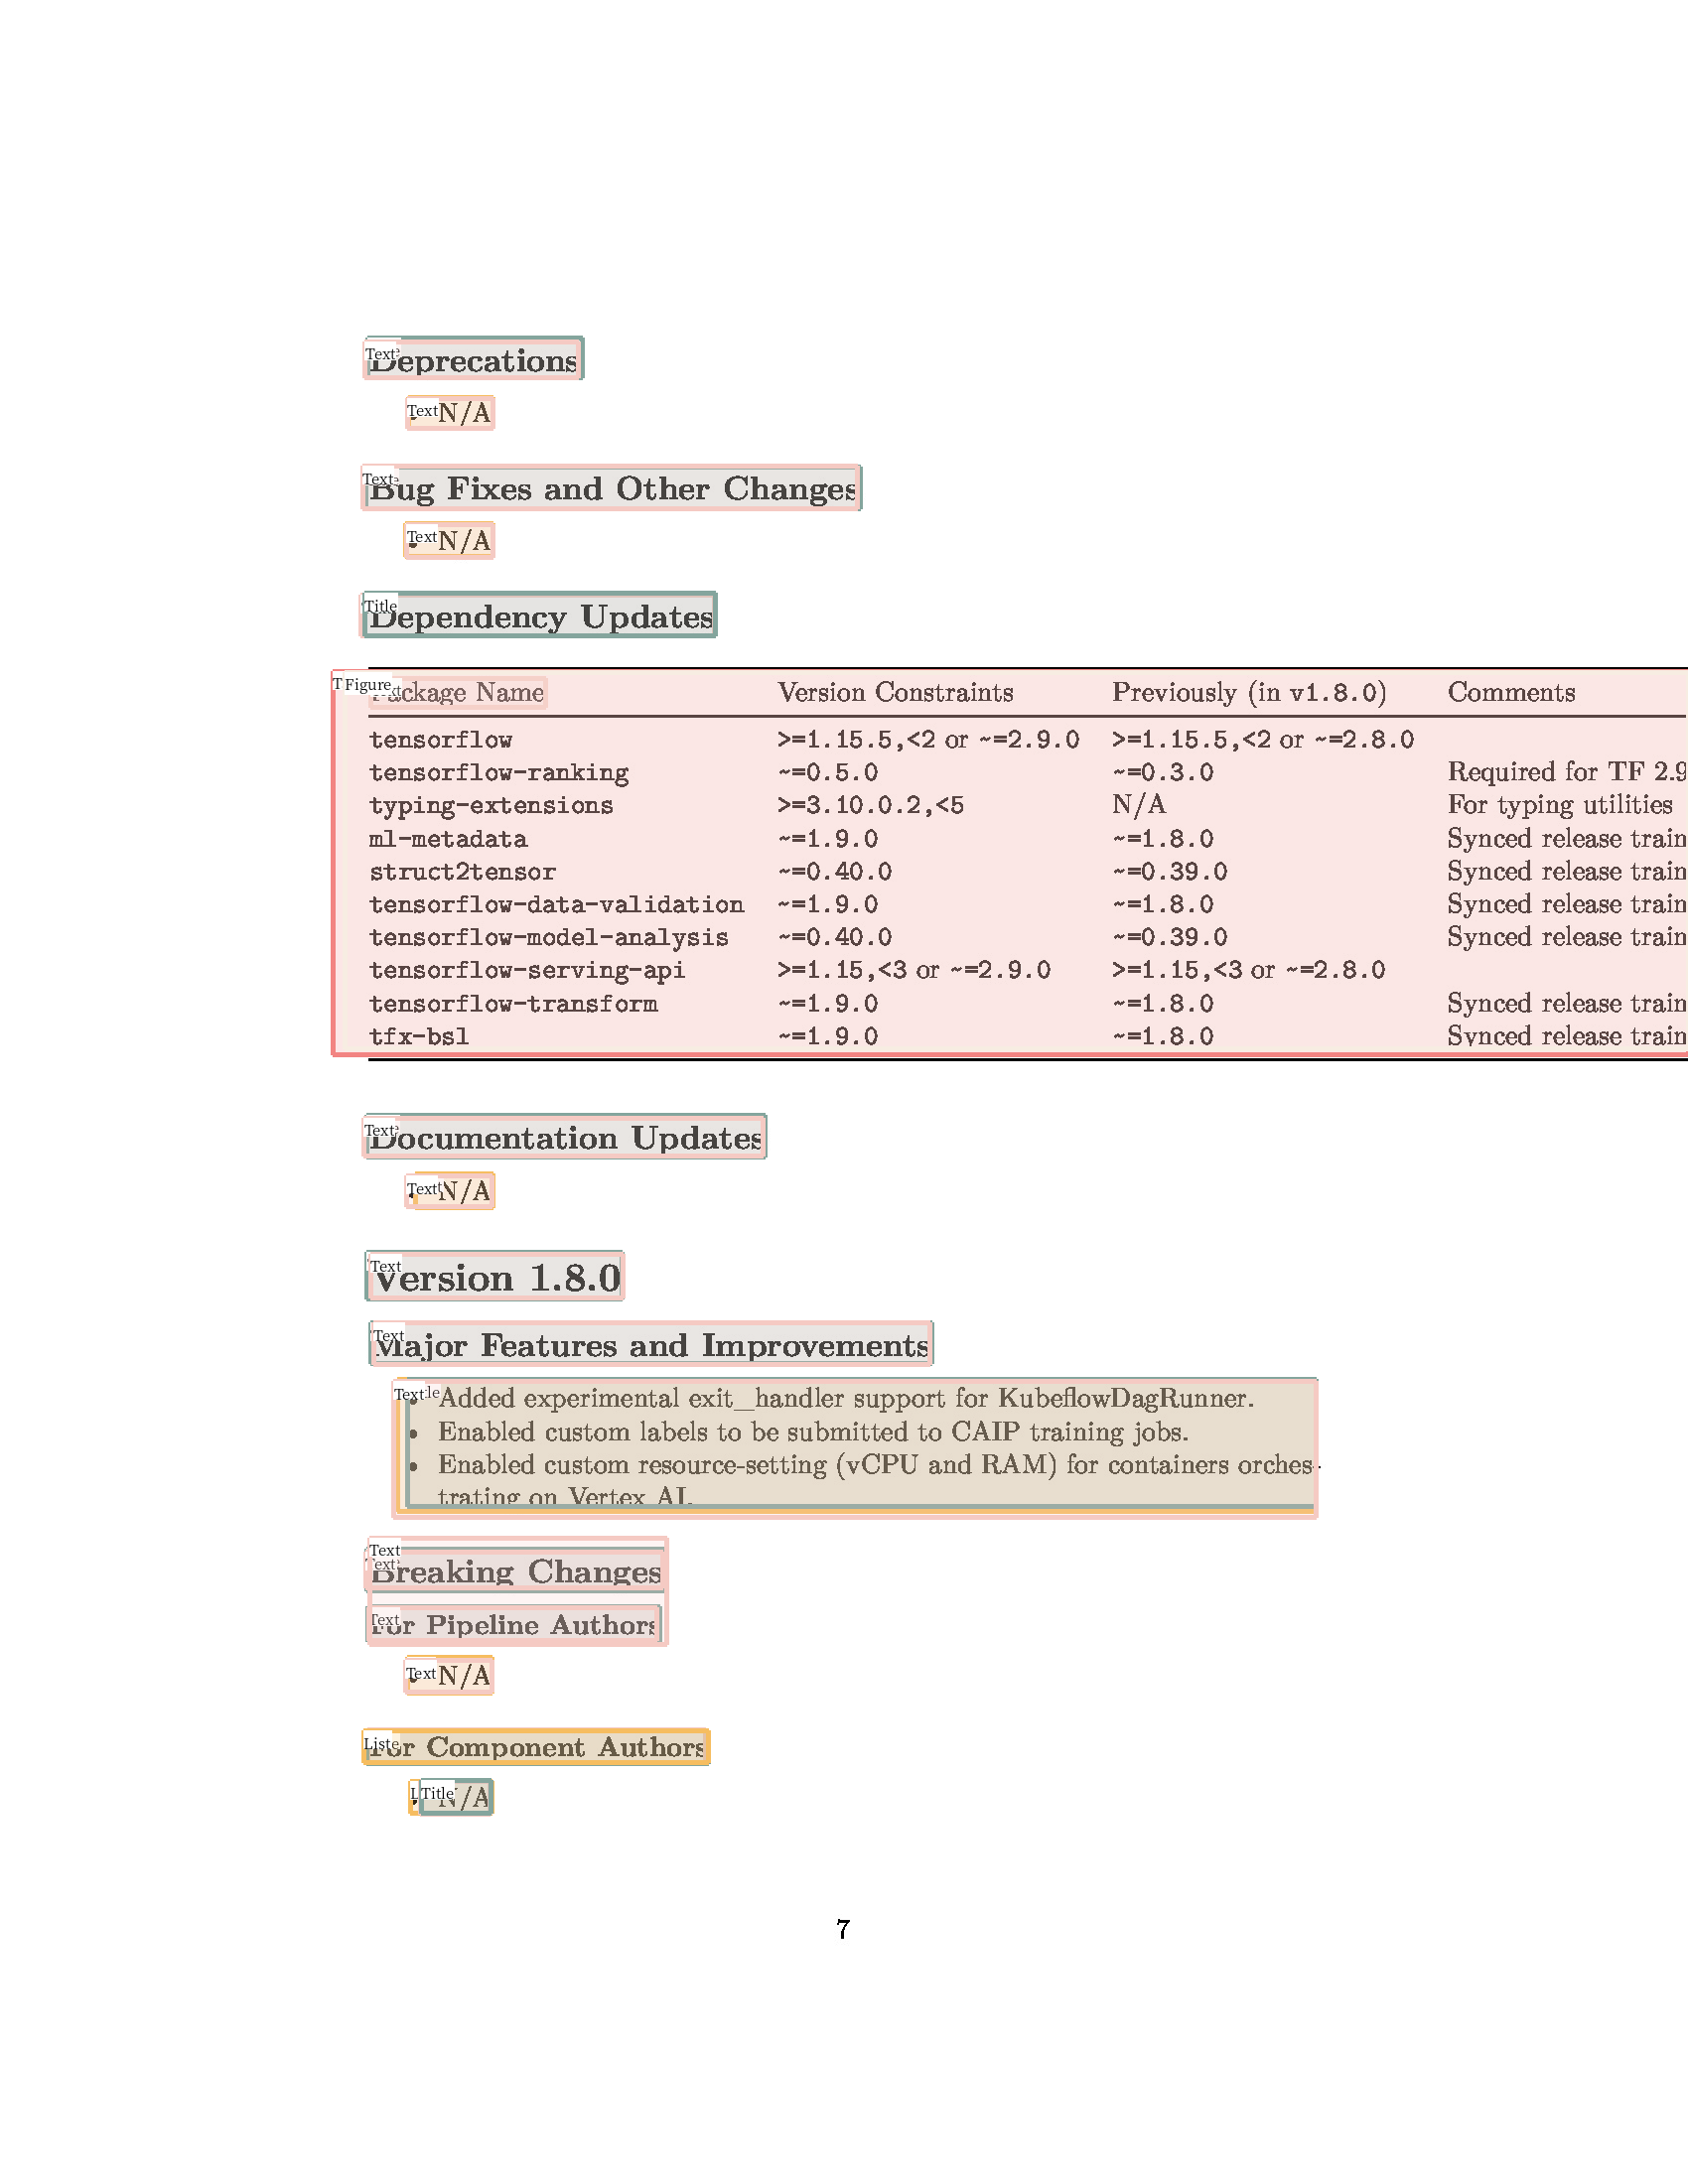

In [15]:
model2 = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 #extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout2 = model.detect(image) 
lp.draw_box(image, layout2,  box_width=5, box_alpha=0.2, show_element_type=True)

OVERLAPPING
TextBlock(block=Rectangle(x_1=100, y_1=100, x_2=100, y_2=100), text=None, id=None, type=Text, parent=None, next=None, score=(0.32214704900979996,))
{'x_1': 100, 'y_1': 100, 'x_2': 100, 'y_2': 100, 'block_type': 'rectangle', 'type': 'Text', 'score': (0.2760590724647045,)}


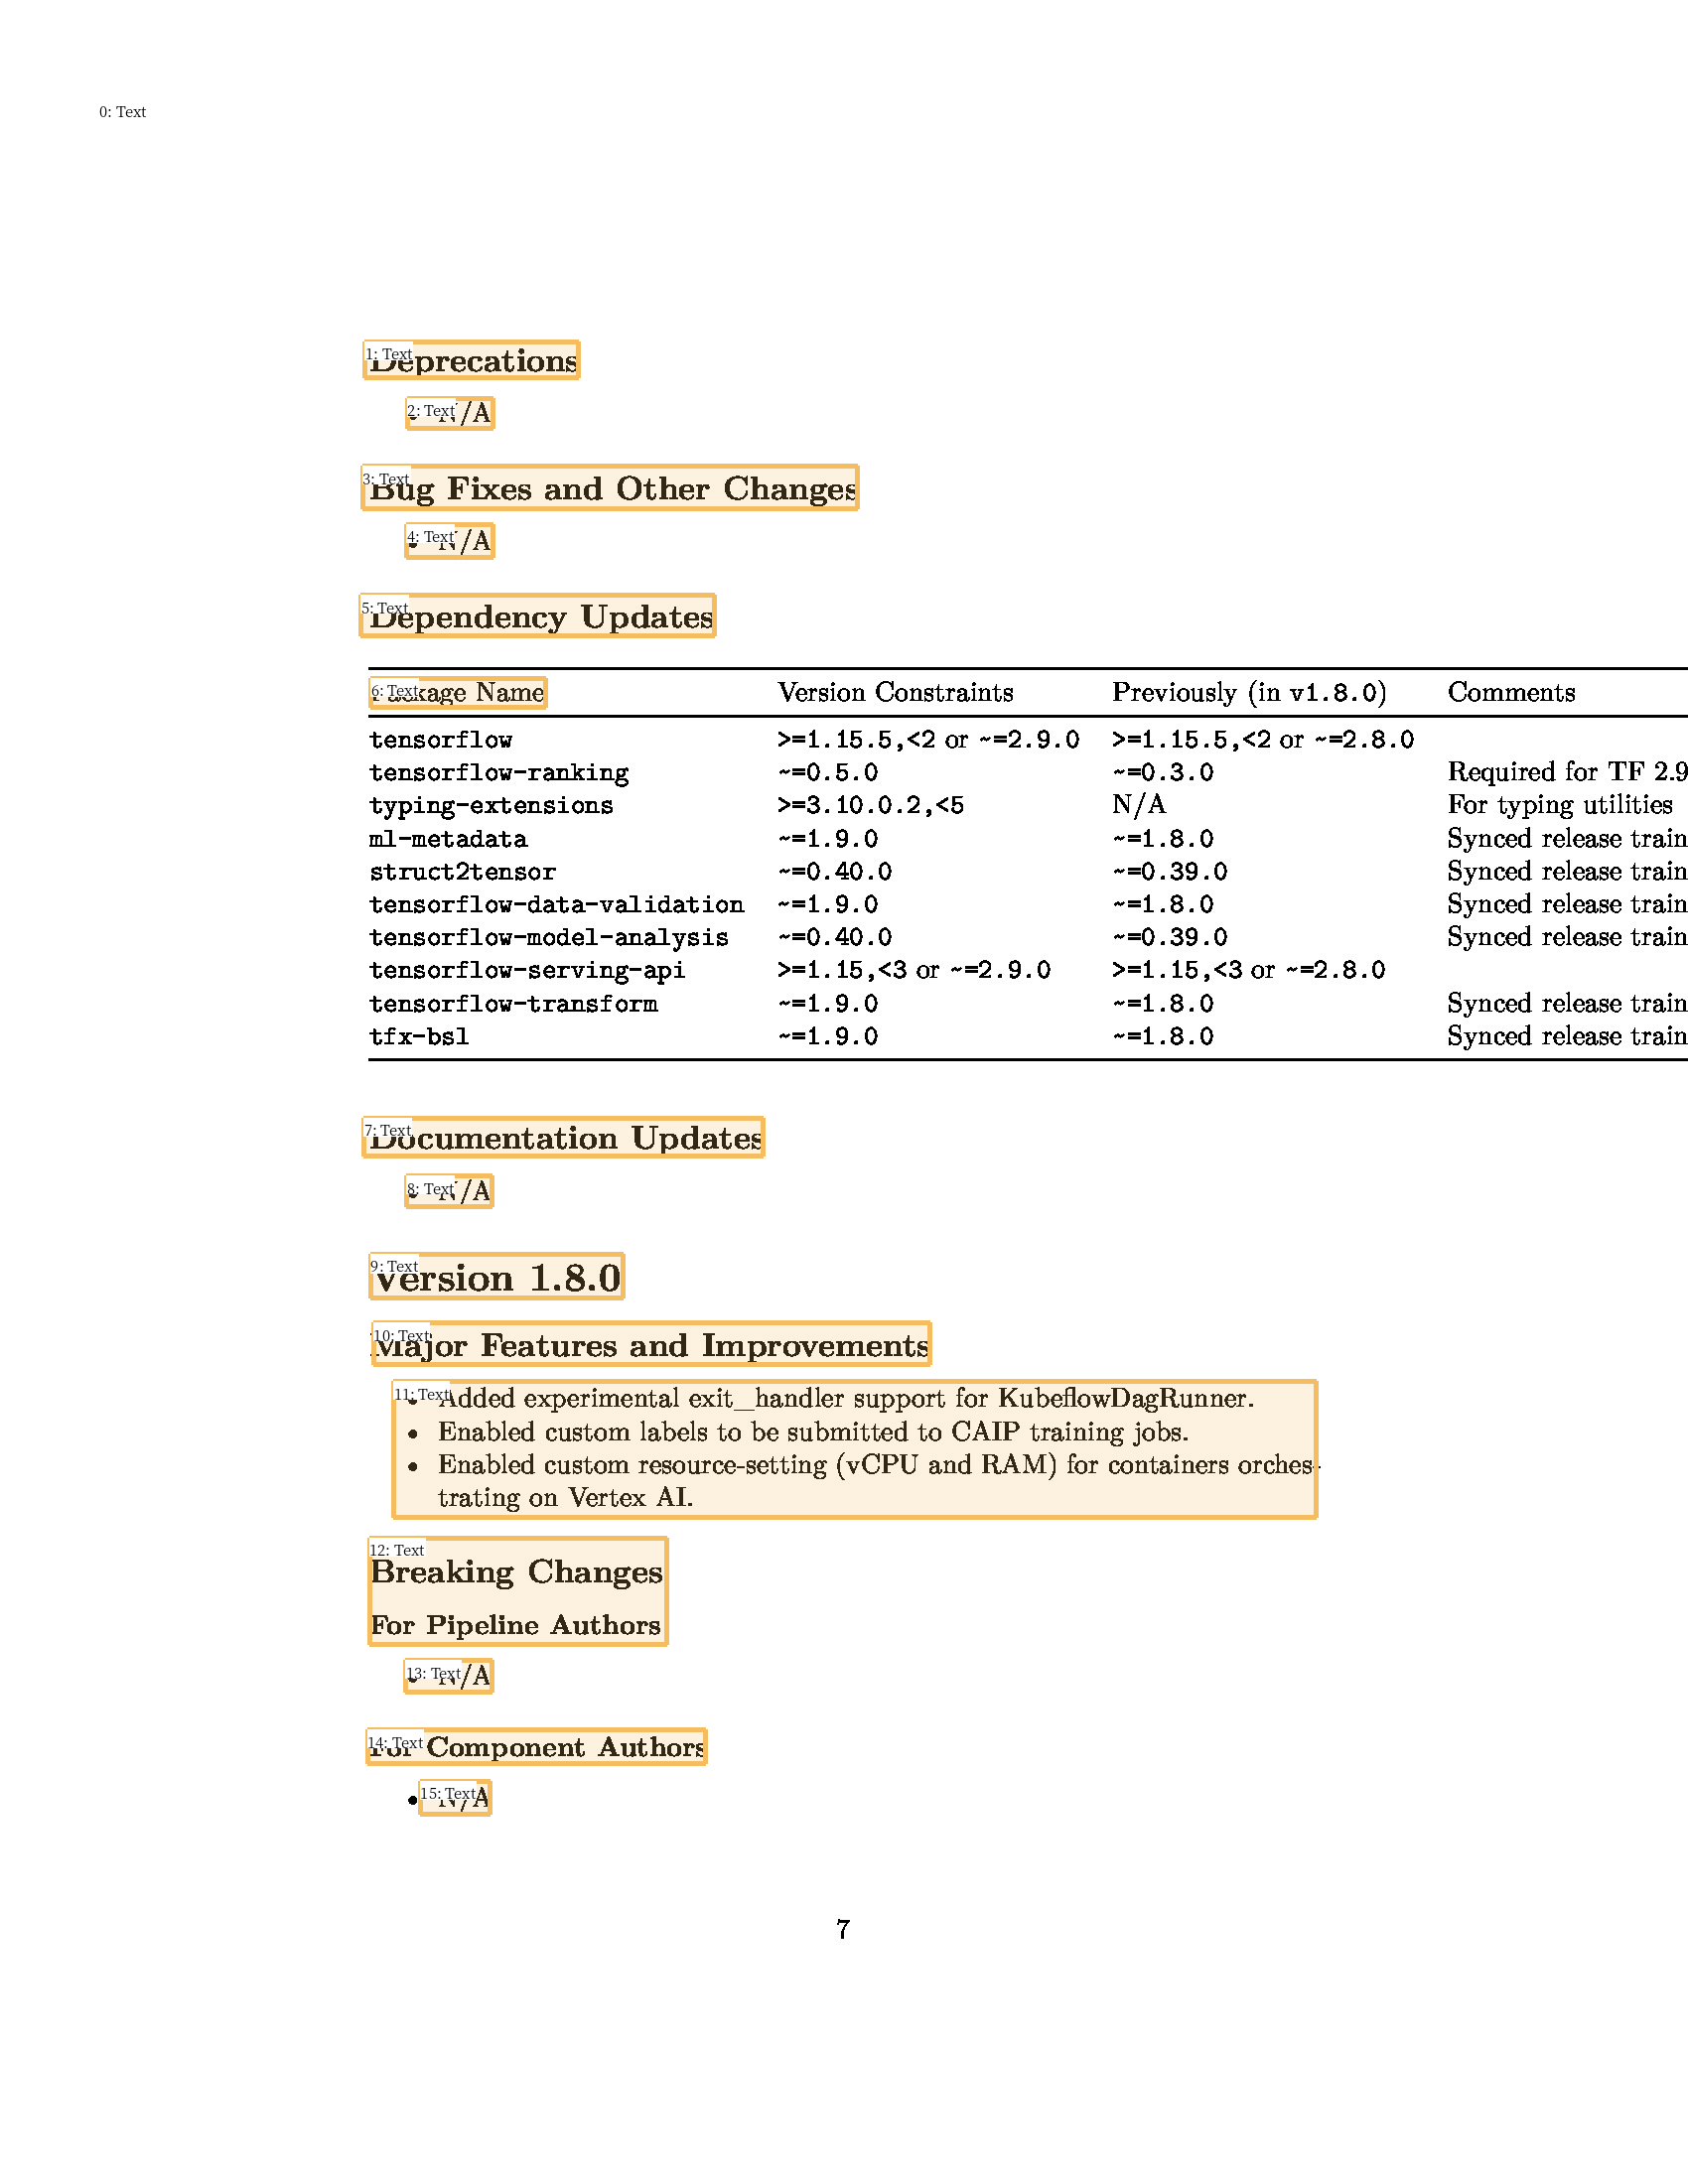

In [24]:
def set_coordinate(data):
    x1= data.block.x_1
    y1= data.block.y_1
    x2= data.block.x_2
    y2= data.block.y_2
    return torch.tensor([[x1,y1,x2,y2]], dtype=torch.float)

def compute_iou(box_1,box_2):
    return bops.box_iou(box_1,box_2)

def merge(block_1, block_2):
    # compute bounding boxes
    bb1 = set_coordinate(block_1)
    bb2 = set_coordinate(block_2)

    # compute Intersection over Union
    iou = compute_iou(bb1,bb2)
    print(iou)
    
    # check if bb are overlapped
    if iou.tolist()[0][0] != 0:
        print("OVERLAPPING")
        print(block_1)

        block_1.block.x_1 = min(block_1.block.x_1, block_2.block.x_1)
        block_1.block.y_1 = min(block_1.block.y_1, block_2.block.y_1)
        block_1.block.x_2 = max(block_1.block.x_2, block_2.block.x_2)
        block_1.block.y_2 = max(block_1.block.y_2, block_2.block.y_2)

        block_1.score=(block_1.score[0] + block_2.score) / 2,

        print(block_1.to_dict())
        
        tb.remove(block_2)

tb = lp.Layout([b for b in layout2 if b.type=='Text'])

for layout_i in tb:
    for layout_j in tb:
        if layout_i != layout_j:
            merge(layout_i,layout_j)

text_blocks_2 = lp.Layout([b for b in tb if b.type=='Text'])

ord_blocks = text_blocks_2._blocks
ord_blocks.sort(key = lambda b:b.coordinates[1])

text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(ord_blocks)])



lp.draw_box(image, text_blocks_2,
            box_width=5,
            box_alpha=0.2,
            show_element_type=True,
            show_element_id=True)